In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [9]:
train_path = os.path.join('data','train.csv')
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(os.path.join('data','test.csv'))

array([[<Axes: title={'center': 'Course'}>]], dtype=object)

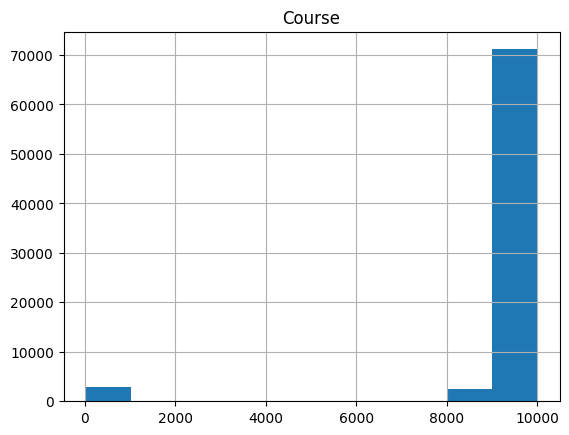

In [10]:
df.hist('Course')
